In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import io
import pickle
import json

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

from uNetModel import *
from encoder import *
from Unet_pretrained import *
from DeeperUnet import *

In [3]:
# For this cell used same code from PyTorch notebook in assignment 2 of Stanford's CS231n Spring 2018 offering
preprocessData = False # To preprocess data set this to True
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    dtype = torch.float32

# Constant to control how frequently we print train loss
print_every = 1

print('using device:', device)

using device: cuda


In [4]:
# For this cell, code belongs to [1]. Minor changes made to accomodate to our use 
# (Using PyTorch instead of Keras/tensorflow)
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
PATH = './stage1_train/'
epsilon = 1e-12 #For numerical stability

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 1
random.seed = seed
np.random.seed = seed

In [5]:
# Opening up json file that contains preprocessed images
with open('processedData.json') as f:
    data = json.load(f)

X_train = np.array(data['X_train'])
Y_train = np.array(data['Y_train'])
X_val = np.array(data['X_val'])
Y_val = np.array(data['Y_val'])
X_test = np.array(data['X_test'])
Y_test = np.array(data['Y_test'])

print('Shape of X_train = ', X_train.shape)
print('Shape of Y_train = ', Y_train.shape)
print('Shape of X_val = ', X_val.shape)
print('Shape of Y_val = ', Y_val.shape)
print('Shape of X_test = ', X_test.shape)
print('Shape of Y_test = ', Y_test.shape)

Shape of X_train =  (402, 3, 128, 128)
Shape of Y_train =  (402, 1, 128, 128)
Shape of X_val =  (134, 3, 128, 128)
Shape of Y_val =  (134, 1, 128, 128)
Shape of X_test =  (134, 3, 128, 128)
Shape of Y_test =  (134, 1, 128, 128)


In [6]:
def showVisualComparisons(y, pred):
    y_reshaped = np.transpose(y, (1,2,0))
    pred_reshaped = np.transpose(pred, (1,2,0))
    imshow(np.squeeze(np.uint8(y_reshaped)))
    plt.show()
    imshow(np.squeeze(np.uint8(pred_reshaped)))
    plt.show()

In [7]:
def calculatePerformance(X_perf, Y_perf, model, mini_batch_size =  64, visual = False):
    D = 1
    for i in range(len(Y_perf.shape)):
        D *= Y_perf.shape[i]
    model.eval() #set model to evaluation mode
    numCorrect = 0
    num_batches = int(X_perf.shape[0]/mini_batch_size)
    num_remaining = X_perf.shape[0] - num_batches *mini_batch_size
    with torch.no_grad():
        for i in range(num_batches):
            x = torch.from_numpy(X_perf[i*mini_batch_size:(i+1)*mini_batch_size, :, :, :])
            y = torch.from_numpy(Y_perf[i*mini_batch_size:(i+1)*mini_batch_size, :, :, :]).type(torch.cuda.FloatTensor)
            x = x.to(device = device, dtype = dtype)
            preds = model(x)
            preds = (preds > 0.5).type(preds.type())
            numCorrect += (preds==y).sum()
        x = torch.from_numpy(X_perf[num_batches*mini_batch_size:, :, :, :])
        y = torch.from_numpy(Y_perf[num_batches*mini_batch_size:, :, :, :]).type(torch.cuda.FloatTensor)
        x = x.to(device = device, dtype = dtype)
        preds = model(x)
        preds = (preds > 0.5).type(preds.type())
        if visual:
            ix = np.random.randint((num_batches*mini_batch_size), X_perf.shape[0])
            showVisualComparisons(Y_perf[ix, :, :, :], preds[(ix - (num_batches*mini_batch_size)), :, :, :].cpu().numpy())
        numCorrect += (preds==y).sum()
    return float(numCorrect)/float(D)

In [11]:
def calc_iou(preds, y):
    preds = preds.view(preds.shape[0], -1)
    y = y.view(y.shape[0], -1)
    intersection = (y*preds.type(torch.float)).sum()
    union = y.sum() + (preds.type(torch.float)).sum() - intersection
    return (intersection/(union))

In [8]:
def calculatePerformanceIOU(X_perf, Y_perf, model, mini_batch_size =  64,visual = False):
    model.eval() #set model to evaluation mode
    mean_iou = 0
    num_batches = int(len(X_perf)/mini_batch_size)
    num_remaining = len(X_perf) - num_batches *mini_batch_size
    with torch.no_grad():
        for i in range(num_batches):
            x = torch.from_numpy(X_perf[i*mini_batch_size:(i+1)*mini_batch_size, :, :, :])
            y = torch.from_numpy(Y_perf[i*mini_batch_size:(i+1)*mini_batch_size, :, :, :])
            x = x.to(device = device, dtype = dtype)
            y = y.to(device = device, dtype = dtype)
            preds = model(x)
            preds = (preds > 0.5)
            mean_iou += float(mini_batch_size)*calc_iou(preds, y)
        x = torch.from_numpy(X_perf[num_batches*mini_batch_size:, :, :, :])
        y = torch.from_numpy(Y_perf[num_batches*mini_batch_size:, :, :, :])
        x = x.to(device = device, dtype = dtype)
        y = y.to(device = device, dtype = dtype)
        preds = model(x)
        preds = (preds > 0.5)
        if visual:
            ix = np.random.randint((num_batches*mini_batch_size), X_perf.shape[0])
            showVisualComparisons(Y_perf[ix, :, :, :], preds[(ix - (num_batches*mini_batch_size)), :, :, :].cpu().numpy())
        mean_iou += float(num_remaining)*calc_iou(preds, y)
    return (mean_iou/(float(X_perf.shape[0])))

In [14]:
def Dice_Loss(preds,y):
    q = 1.
    x = preds.view(-1)
    z = y.view(-1)
    intersection = (x * z).sum()
    return 1.0 - (((2. * intersection + q) / (x.sum() + z.sum() + q)))

In [15]:
def trainModel(model, x_train, y_train, optimizer, epochs = 1, mini_batch_size = 64, noVal = False):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    T = 0
    num_batches = int(len(x_train)/mini_batch_size)
    num_remaining = len(x_train) - num_batches *mini_batch_size
    loss_history = []
    for e in range(epochs):
        for t in range(num_batches):
            rand_indices = np.random.choice(len(x_train), mini_batch_size)
            x = torch.from_numpy(x_train[rand_indices, :, :, :])
            y = torch.from_numpy(y_train[rand_indices, :, :, :])
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            preds = model(x)
            loss = Dice_Loss(preds, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if T % print_every == 0:
                currLoss = loss.item()
                loss_history.append(currLoss)
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, currLoss))
            if (num_remaining <= 0 and t == (num_batches -1)):
                percentCorrect = calculatePerformance(x_train, y_train, model)
                print('Train percent correct at epoch %d is %.4f' % (e, percentCorrect))
                if (noVal == False):
                    percentCorrect = calculatePerformance(X_val, Y_val, model)
                    print('Val percent correct at epoch %d is %.4f' % (e, percentCorrect))
            T +=1
        if num_remaining > 0:
            rand_indices = np.random.choice(len(x_train), num_remaining)
            x = torch.from_numpy(x_train[rand_indices, :, :, :])
            y = torch.from_numpy(y_train[rand_indices, :, :, :])
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            preds = model(x)
            loss = Dice_Loss(preds, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            if T % print_every == 0:
                currLoss = loss.item()
                loss_history.append(currLoss)
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, num_batches, currLoss))
            percentCorrect = calculatePerformance(x_train, y_train, model)
            print('Train percent correct at epoch %d is %.4f' % (e, percentCorrect))
            if (noVal == False):
                percentCorrect = calculatePerformance(X_val, Y_val, model)
                print('Val percent correct at epoch %d is %.4f' % (e, percentCorrect))
            T +=1
    return calculatePerformance(x_train, y_train, model),loss_history

In [20]:
x_train = X_train[:50,:,:,:]
y_train = Y_train[:50, :,:,:]
print_every = 1
bestPerf = -1
bestLossHistory = None
lossHistories = {}
print_every = 1
bestModel = None
bestLoss = 10000
lrUsed = 0
lrs = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
for lr in lrs:
    model = UNet()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    modelPerf, lossHistory = trainModel(model, x_train, y_train, optimizer, epochs = 25, noVal = True)
    lossHistories[str(lr)] = lossHistory
    if lossHistory[len(lossHistory)-1] < bestLoss:
        bestLoss = lossHistory[len(lossHistory)-1]
        bestPerf = modelPerf
        bestLossHistory = lossHistory
        bestModel = model
        lrUsed = lr

Epoch 0, Iteration 0, loss = 0.9520
Train percent correct at epoch 0 is 0.6106
Epoch 1, Iteration 0, loss = 0.7806
Train percent correct at epoch 1 is 0.5091
Epoch 2, Iteration 0, loss = 0.7585
Train percent correct at epoch 2 is 0.5060
Epoch 3, Iteration 0, loss = 0.7996
Train percent correct at epoch 3 is 0.5056
Epoch 4, Iteration 0, loss = 0.7469
Train percent correct at epoch 4 is 0.5048
Epoch 5, Iteration 0, loss = 0.7556
Train percent correct at epoch 5 is 0.5016
Epoch 6, Iteration 0, loss = 0.7611
Train percent correct at epoch 6 is 0.4996
Epoch 7, Iteration 0, loss = 0.7414
Train percent correct at epoch 7 is 0.4988
Epoch 8, Iteration 0, loss = 0.7606
Train percent correct at epoch 8 is 0.4983
Epoch 9, Iteration 0, loss = 0.7329
Train percent correct at epoch 9 is 0.4974
Epoch 10, Iteration 0, loss = 0.7226
Train percent correct at epoch 10 is 0.4970
Epoch 11, Iteration 0, loss = 0.7616
Train percent correct at epoch 11 is 0.4969
Epoch 12, Iteration 0, loss = 0.7527
Train perce

Epoch 3, Iteration 0, loss = 0.8209
Train percent correct at epoch 3 is 0.6236
Epoch 4, Iteration 0, loss = 0.8063
Train percent correct at epoch 4 is 0.6235
Epoch 5, Iteration 0, loss = 0.8281
Train percent correct at epoch 5 is 0.6235
Epoch 6, Iteration 0, loss = 0.7987
Train percent correct at epoch 6 is 0.6234
Epoch 7, Iteration 0, loss = 0.8104
Train percent correct at epoch 7 is 0.6233
Epoch 8, Iteration 0, loss = 0.8081
Train percent correct at epoch 8 is 0.6232
Epoch 9, Iteration 0, loss = 0.8142
Train percent correct at epoch 9 is 0.6231
Epoch 10, Iteration 0, loss = 0.8225
Train percent correct at epoch 10 is 0.6231
Epoch 11, Iteration 0, loss = 0.8106
Train percent correct at epoch 11 is 0.6230
Epoch 12, Iteration 0, loss = 0.8215
Train percent correct at epoch 12 is 0.6230
Epoch 13, Iteration 0, loss = 0.8147
Train percent correct at epoch 13 is 0.6229
Epoch 14, Iteration 0, loss = 0.7915
Train percent correct at epoch 14 is 0.6228
Epoch 15, Iteration 0, loss = 0.8139
Train

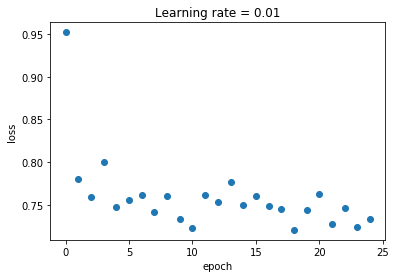

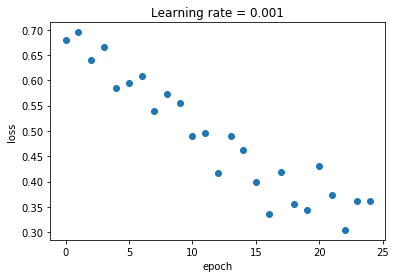

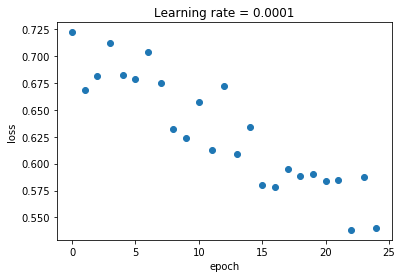

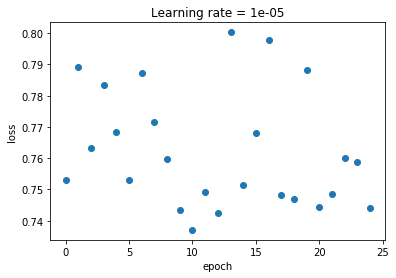

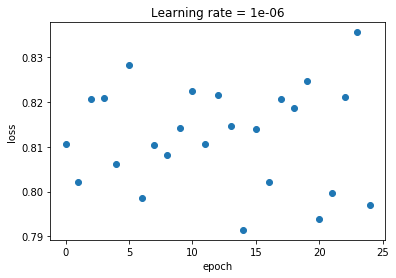

Lowest loss =  0.36112892627716064
Best lr =  0.001


In [21]:
# Let us take a look at the loss history to verify training
for lr, lossHist in lossHistories.items():
    plt.plot((np.arange(len(lossHist))),lossHist, 'o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Learning rate = '+ lr)
    plt.show()
print('Lowest loss = ', str(bestLossHistory[len(bestLossHistory)-1]))
print('Best lr = ', str(lrUsed))

In [58]:
x_train = X_train[:50,:,:,:]
y_train = Y_train[:50, :,:,:]
print_every = 1
bestPerf = -1
bestLossHistory = None
lossHistories = {}
print_every = 2
bestModel = None
bestLoss = 10000
lrUsed = 0
lrs = [.002790131320016961, 0.001118207258171186]
for i in range(4):
     lrs.append(.05*np.random.random())
for lr in lrs:
    model = UNet()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    modelPerf, lossHistory = trainModel(model, x_train, y_train, optimizer, epochs = 30, noVal = True)
    lossHistories[str(lr)] = lossHistory
    if lossHistory[len(lossHistory)-1] < bestLoss:
        bestLoss = lossHistory[len(lossHistory)-1]
        bestPerf = modelPerf
        bestLossHistory = lossHistory
        bestModel = model
        lrUsed = lr

Epoch 0, Iteration 0, loss = 0.6772
Train percent correct at epoch 0 is 0.5734
Train percent correct at epoch 1 is 0.5842
Epoch 2, Iteration 0, loss = 0.7750
Train percent correct at epoch 2 is 0.5461
Train percent correct at epoch 3 is 0.5062
Epoch 4, Iteration 0, loss = 0.7564
Train percent correct at epoch 4 is 0.4573
Train percent correct at epoch 5 is 0.4573
Epoch 6, Iteration 0, loss = 0.7463
Train percent correct at epoch 6 is 0.4430
Train percent correct at epoch 7 is 0.4221
Epoch 8, Iteration 0, loss = 0.7541
Train percent correct at epoch 8 is 0.4070
Train percent correct at epoch 9 is 0.3885
Epoch 10, Iteration 0, loss = 0.7479
Train percent correct at epoch 10 is 0.3764
Train percent correct at epoch 11 is 0.3771
Epoch 12, Iteration 0, loss = 0.7630
Train percent correct at epoch 12 is 0.3822
Train percent correct at epoch 13 is 0.4024
Epoch 14, Iteration 0, loss = 0.7632
Train percent correct at epoch 14 is 0.3971
Train percent correct at epoch 15 is 0.4010
Epoch 16, Itera

Train percent correct at epoch 12 is 0.8365
Train percent correct at epoch 13 is 0.8365
Epoch 14, Iteration 0, loss = 1.0000
Train percent correct at epoch 14 is 0.8365
Train percent correct at epoch 15 is 0.8365
Epoch 16, Iteration 0, loss = 1.0000
Train percent correct at epoch 16 is 0.8365
Train percent correct at epoch 17 is 0.8365
Epoch 18, Iteration 0, loss = 1.0000
Train percent correct at epoch 18 is 0.8365
Train percent correct at epoch 19 is 0.8365
Epoch 20, Iteration 0, loss = 1.0000
Train percent correct at epoch 20 is 0.8365
Train percent correct at epoch 21 is 0.8365
Epoch 22, Iteration 0, loss = 1.0000
Train percent correct at epoch 22 is 0.8365
Train percent correct at epoch 23 is 0.8365
Epoch 24, Iteration 0, loss = 1.0000
Train percent correct at epoch 24 is 0.8365
Train percent correct at epoch 25 is 0.8365
Epoch 26, Iteration 0, loss = 1.0000
Train percent correct at epoch 26 is 0.8365
Train percent correct at epoch 27 is 0.8365
Epoch 28, Iteration 0, loss = 1.0000


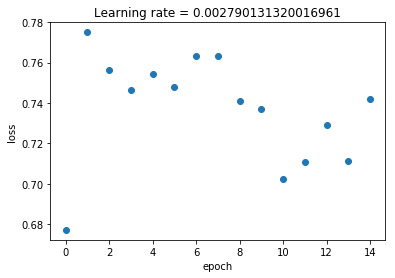

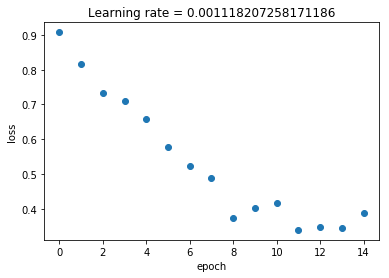

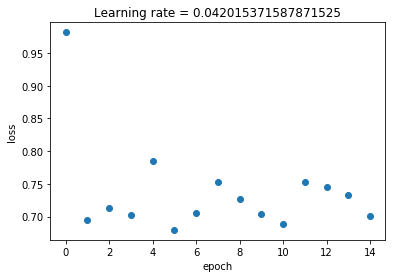

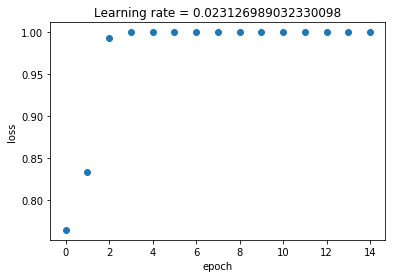

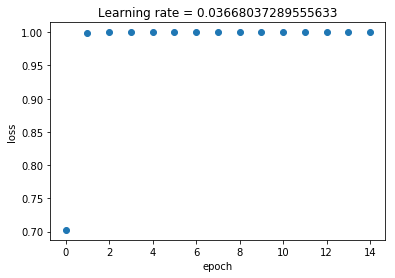

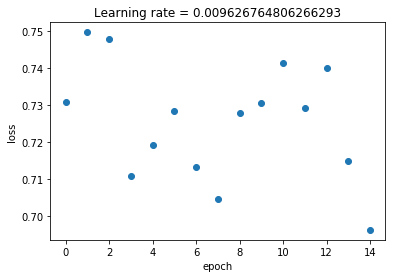

Lowest loss =  0.38775038719177246
Best lr =  0.001118207258171186


In [59]:
# Let us take a look at the loss history to verify training
for lr, lossHist in lossHistories.items():
    plt.plot((np.arange(len(lossHist))),lossHist, 'o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Learning rate = '+ lr)
    plt.show()
print('Lowest loss = ', str(bestLossHistory[len(bestLossHistory)-1]))
print('Best lr = ', str(lrUsed))

Epoch 0, Iteration 0, loss = 0.6875
Epoch 0, Iteration 2, loss = 0.7078
Epoch 0, Iteration 4, loss = 0.6648
Epoch 0, Iteration 6, loss = 0.6748
Train percent correct at epoch 0 is 0.4234
Epoch 1, Iteration 1, loss = 0.6816
Epoch 1, Iteration 3, loss = 0.6112
Epoch 1, Iteration 5, loss = 0.5833
Train percent correct at epoch 1 is 0.6427
Epoch 2, Iteration 0, loss = 0.5214
Epoch 2, Iteration 2, loss = 0.5019
Epoch 2, Iteration 4, loss = 0.4748
Epoch 2, Iteration 6, loss = 0.4200
Train percent correct at epoch 2 is 0.7639
Epoch 3, Iteration 1, loss = 0.4794
Epoch 3, Iteration 3, loss = 0.4358
Epoch 3, Iteration 5, loss = 0.4230
Train percent correct at epoch 3 is 0.8079
Epoch 4, Iteration 0, loss = 0.3895
Epoch 4, Iteration 2, loss = 0.3362
Epoch 4, Iteration 4, loss = 0.3498
Epoch 4, Iteration 6, loss = 0.2159
Train percent correct at epoch 4 is 0.9366
Epoch 5, Iteration 1, loss = 0.2559
Epoch 5, Iteration 3, loss = 0.2153
Epoch 5, Iteration 5, loss = 0.2552
Train percent correct at epoc

Epoch 47, Iteration 5, loss = 0.0844
Train percent correct at epoch 47 is 0.9709
Epoch 48, Iteration 0, loss = 0.0846
Epoch 48, Iteration 2, loss = 0.1036
Epoch 48, Iteration 4, loss = 0.0909
Epoch 48, Iteration 6, loss = 0.1063
Train percent correct at epoch 48 is 0.9718
Epoch 49, Iteration 1, loss = 0.1027
Epoch 49, Iteration 3, loss = 0.0918
Epoch 49, Iteration 5, loss = 0.1087
Train percent correct at epoch 49 is 0.9715
Epoch 50, Iteration 0, loss = 0.0896
Epoch 50, Iteration 2, loss = 0.0950
Epoch 50, Iteration 4, loss = 0.1084
Epoch 50, Iteration 6, loss = 0.0804
Train percent correct at epoch 50 is 0.9720
Epoch 51, Iteration 1, loss = 0.0809
Epoch 51, Iteration 3, loss = 0.0825
Epoch 51, Iteration 5, loss = 0.0732
Train percent correct at epoch 51 is 0.9717
Epoch 52, Iteration 0, loss = 0.0759
Epoch 52, Iteration 2, loss = 0.0904
Epoch 52, Iteration 4, loss = 0.0951
Epoch 52, Iteration 6, loss = 0.0753
Train percent correct at epoch 52 is 0.9717
Epoch 53, Iteration 1, loss = 0.0

Train percent correct at epoch 94 is 0.9742
Epoch 95, Iteration 1, loss = 0.1001
Epoch 95, Iteration 3, loss = 0.0945
Epoch 95, Iteration 5, loss = 0.0681
Train percent correct at epoch 95 is 0.9744
Epoch 96, Iteration 0, loss = 0.0840
Epoch 96, Iteration 2, loss = 0.0827
Epoch 96, Iteration 4, loss = 0.0719
Epoch 96, Iteration 6, loss = 0.0997
Train percent correct at epoch 96 is 0.9741
Epoch 97, Iteration 1, loss = 0.0840
Epoch 97, Iteration 3, loss = 0.1046
Epoch 97, Iteration 5, loss = 0.0910
Train percent correct at epoch 97 is 0.9746
Epoch 98, Iteration 0, loss = 0.0621
Epoch 98, Iteration 2, loss = 0.0667
Epoch 98, Iteration 4, loss = 0.0828
Epoch 98, Iteration 6, loss = 0.0871
Train percent correct at epoch 98 is 0.9748
Epoch 99, Iteration 1, loss = 0.0869
Epoch 99, Iteration 3, loss = 0.0905
Epoch 99, Iteration 5, loss = 0.0745
Train percent correct at epoch 99 is 0.9747
Epoch 100, Iteration 0, loss = 0.0742
Epoch 100, Iteration 2, loss = 0.0930
Epoch 100, Iteration 4, loss = 

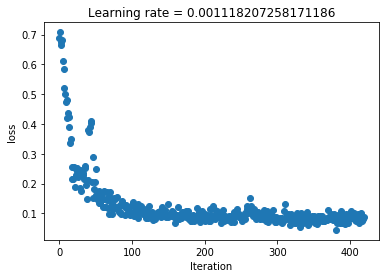

In [60]:
model = UNet()
optimizer = optim.Adam(model.parameters(), lr = lrUsed)
modelPerf, lossHistory = trainModel(model, X_train, Y_train, optimizer, epochs = 120, noVal = True)
plt.plot((np.arange(len(lossHistory))),lossHistory, 'o')
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Learning rate = '+ str(lrUsed))
plt.show()
torch.save(model, 'bestDiceLossUNet')

In [42]:
BCEModel = torch.load('bestBaselineUNet')
print('Mean IOU on train set (UNet trained with BCE loss) = ', calculatePerformanceIOU(X_train, Y_train, BCEModel, visual = False).cpu().numpy())
print('Mean IOU on val set (UNet trained with BCE loss) = ', calculatePerformanceIOU(X_val, Y_val, BCEModel, visual = False).cpu().numpy())
print('Percent pixels correct on train set (UNet trained with BCE loss) = ', calculatePerformance(X_train, Y_train, BCEModel, visual = False))
print('Percent pixels correct on val set (UNet trained with BCE loss) = ', calculatePerformance(X_val, Y_val, BCEModel, visual = False))

Mean IOU on train set (UNet trained with BCE loss) =  0.84186184
Mean IOU on val set (UNet trained with BCE loss) =  0.79953855
Percent pixels correct on train set (UNet trained with BCE loss) =  0.9731689756782493
Percent pixels correct on val set (UNet trained with BCE loss) =  0.9645909551364272


In [61]:
DiceModel = torch.load('bestDiceLossUNet')
print('Mean IOU on train set (UNet trained with Dice loss) = ', calculatePerformanceIOU(X_train, Y_train, DiceModel, visual = False).cpu().numpy())
print('Mean IOU on val set (UNet trained with Dice loss) = ', calculatePerformanceIOU(X_val, Y_val, DiceModel, visual = False).cpu().numpy())
print('Percent pixels correct on train set (UNet trained with Dice loss) = ', calculatePerformance(X_train, Y_train, DiceModel, visual = False))
print('Percent pixels correct on val set (UNet trained with Dice loss) = ', calculatePerformance(X_val, Y_val, DiceModel, visual = False))

Mean IOU on train set (UNet trained with Dice loss) =  0.8490938
Mean IOU on val set (UNet trained with Dice loss) =  0.8169488
Percent pixels correct on train set (UNet trained with Dice loss) =  0.9747344818874378
Percent pixels correct on val set (UNet trained with Dice loss) =  0.9680617602903452


# References
[1] Amdal-Saevik, K. (2018). Keras U-Net starter - LB 0.277. 
https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277?scriptVersionId=2164855/code

[2] Ho, D. J., Fu, C., Salama, P., Dunn, K. W., and Delp, E. J. (2017, July). Nuclei Segmentation of Fluorescence Microscopy Images Using Three Dimensional Convolutional Neural Networks. In Computer Vision and Pattern Recognition Workshops (CVPRW), 2017 IEEE Conference on (pp. 834-842). IEEE.

[3] Kakade, A., and Dumbali, J. (2018, February). Identification of nerve in ultrasound images using U-net architecture. In 2018 International Conference on Communication information and Computing Technology (ICCICT) (pp. 1-6). IEEE.

[4] Li, X., Chen, H., Qi, X., Dou, Q., Fu, C. W., and Heng, P. A. (2017). H-DenseUNet: Hybrid densely connected UNet for liver and liver tumor segmentation from CT volumes. arXiv preprint arXiv:1709.07330.

[5] Ronneberger, O., Fischer, P., and Brox, T. 
(2015, October). U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.

[6] Pearce, C. Convolutional (2017). Neural Networks and the Analysis of Cancer Imagery.

[7] Imagenet. https://patrykchrabaszcz.github.io/Imagenet32/